In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import metrics
from sympy.utilities.iterables import generate_bell
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def split_clusters(data, labels):
    k = max(labels)
    split = []
    for g in np.arange(k+1):
        its = labels == g
        split.append(data[its])
    return split

def max_dist(cluster):
    dists = sp.spatial.distance.cdist(cluster, cluster, 'euclidean')
    return np.amax(dists)

def min_dists(centroids):
    dists = sp.spatial.distance.cdist(centroids, centroids, 'euclidean')
    min_dist = 1e10
    for i in np.arange(dists.shape[0]):
        for j in np.arange(i+1, dists.shape[1]):
            min_dist = min(min_dist, dists[i][j])
    return min_dist

def dunn_index(data, labels, centroids):
    clusters = split_clusters(data, labels)
    max_d = np.amax(map(lambda c: max_dist(c), clusters))
    min_d = min_dists(centroids)
    return min_d / max_d

def cluster_scatter(data, centroid, p=2):
    x = np.apply_along_axis(lambda r: np.linalg.norm(r), 1, (data-centroid)**p)
    x = (np.sum(x, axis=0) / data.shape[0]) ** (1.0/p)
    return x

def measure_of_separation(c1, c2, p=2):
    return np.linalg.norm((c1 - c2), ord=p)

def db_index(data, labels, centroids):
    clusters = split_clusters(data, labels)
    s = np.zeros((len(clusters)))
    for i in np.arange(len(clusters)):
        s[i] = cluster_scatter(clusters[i], centroids[i])
        
    max_r = 0.0
    d = np.zeros((len(clusters)))
    for i in np.arange(len(clusters)):
        for j in np.arange(i, len(clusters)):
            if i != j:
                r = (s[i] + s[j]) / measure_of_separation(centroids[i], centroids[j])
                d[i] = max(r, d[i])
    return np.sum(d, axis=0) / (len(clusters))

def assess_result(data, labels, centroids):
    silhuette = metrics.silhouette_score(data, labels, metric='euclidean')
    if (len(centroids.shape) == 2):
        dunn = dunn_index(data, labels, centroids)
        dbi = db_index(data, labels, centroids)
    else:
        dunn = None
        dbi = None
    print('silhuette: {}, dunn: {}, davies-bouldin: {}'.format(silhuette, dunn, dbi))

def plot_results(data, labels, centers, k):
    colors = cm.rainbow(np.linspace(0, 1, k))
    d = data.shape[1]
    fig, axes = plt.subplots(d, d)
    fig.subplots_adjust(left=0, right=2, top=2, bottom=0, hspace=.2, wspace=.2)
    subpl_num = 0
    for d1 in np.arange(d):
        for d2 in np.arange(d):
            subpl_num += 1
            if d1 != d2:
                plt.subplot(d, d, subpl_num)
                if len(centers.shape) > 1 and centers.shape[1] > 1:
                    plt.scatter(centers[:, d1], centers[:, d2], marker='x')
                for c in np.arange(k):
                    its = labels == c
                    plt.scatter(data[its, d1], data[its, d2], marker='.')
                no_group = labels == -1
                plt.scatter(data[no_group, d1], data[no_group, d2], marker='.', color='black')
    
    plt.show()

In [39]:
from sklearn import datasets

centers_ = [[1, 1], [3, 3], [5, 1]]
cloud, labels = datasets.make_blobs(n_samples=3000, n_features=2, centers=centers_, cluster_std=0.5)

silhuette: 0.676055400062, dunn: 0.749084167448, davies-bouldin: 0.264683698401


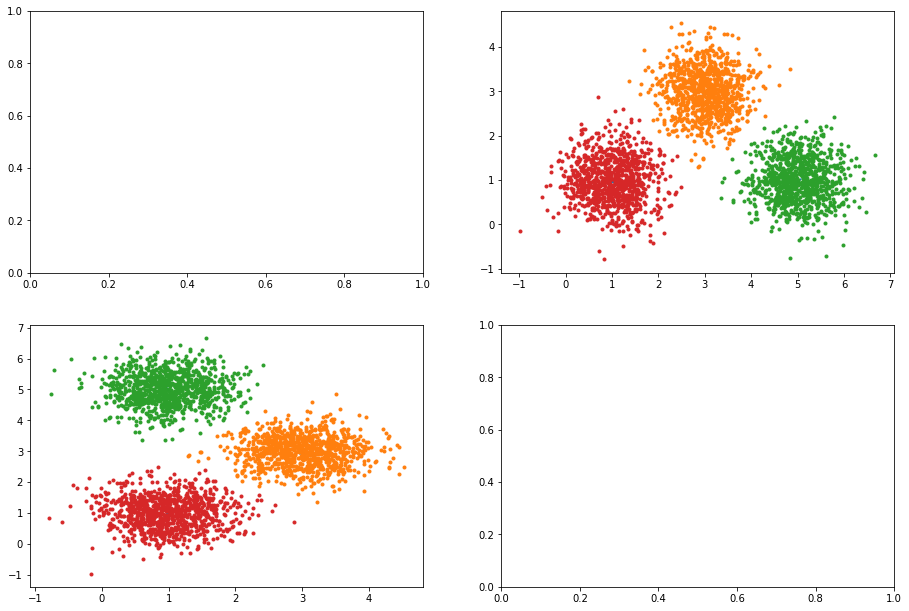

silhuette: 0.676055400062, dunn: 0.749084167448, davies-bouldin: 0.308127181805


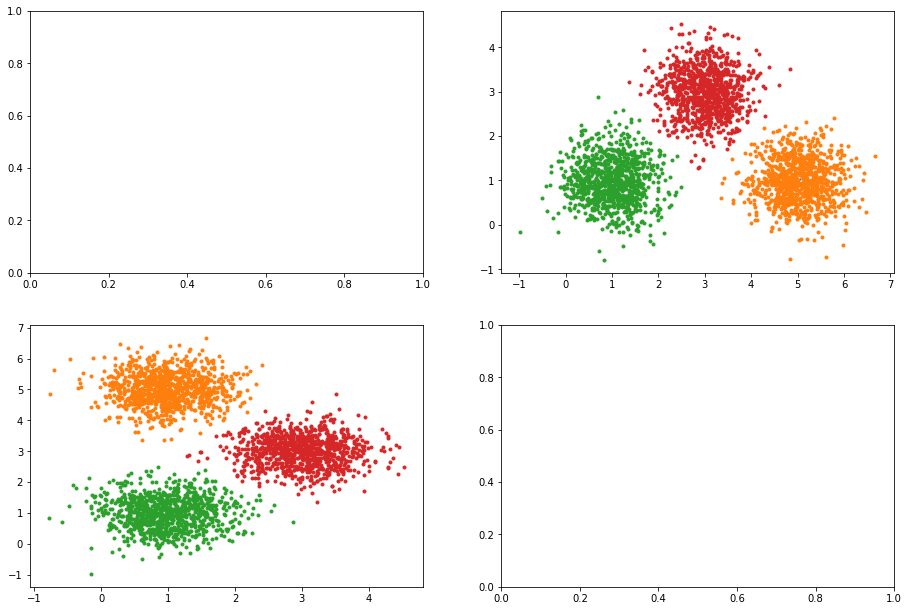

In [43]:
k = 3
for ni in [1, 5]:
    kmeans = KMeans(k, n_init=ni)
    kmeans.fit(cloud)
    assess_result(cloud, kmeans.labels_, kmeans.cluster_centers_)
    plot_results(cloud, kmeans.labels_, kmeans.cluster_centers_, k)

silhuette: 0.530880388497, dunn: 0.0847875576828, davies-bouldin: 0.813813828518


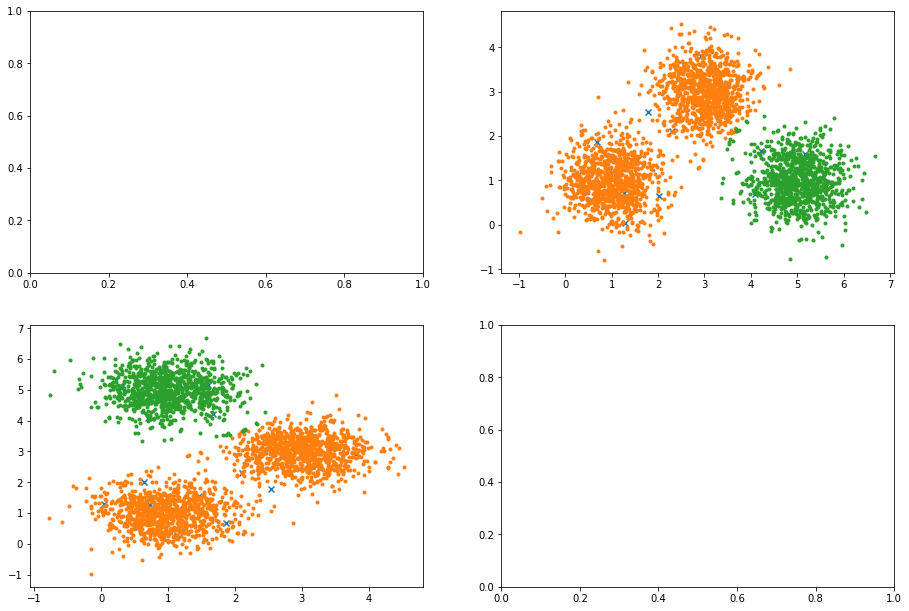

silhuette: 0.671550553228, dunn: 0.149975140138, davies-bouldin: 1.95658605107


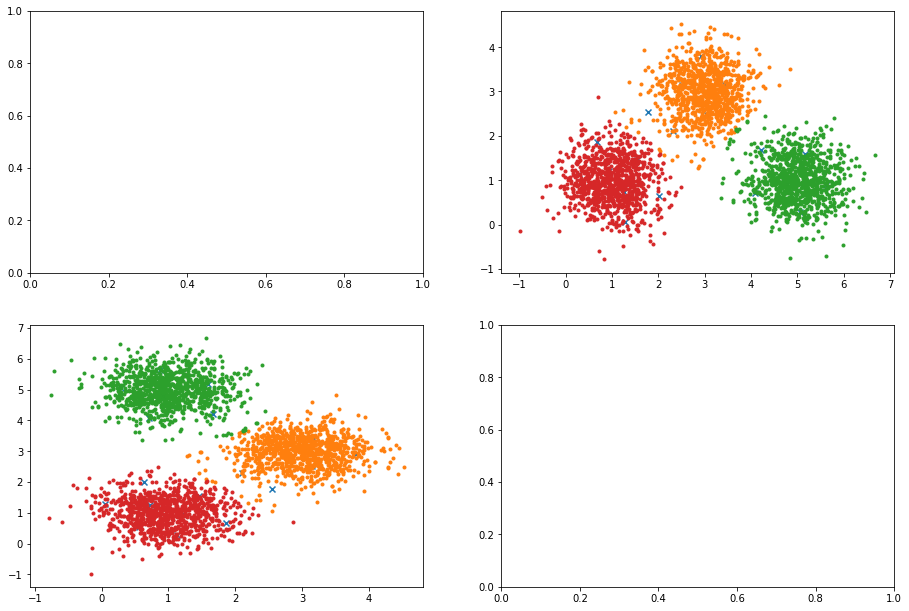

silhuette: 0.276142751341, dunn: 0.233468454739, davies-bouldin: 5.44455920359


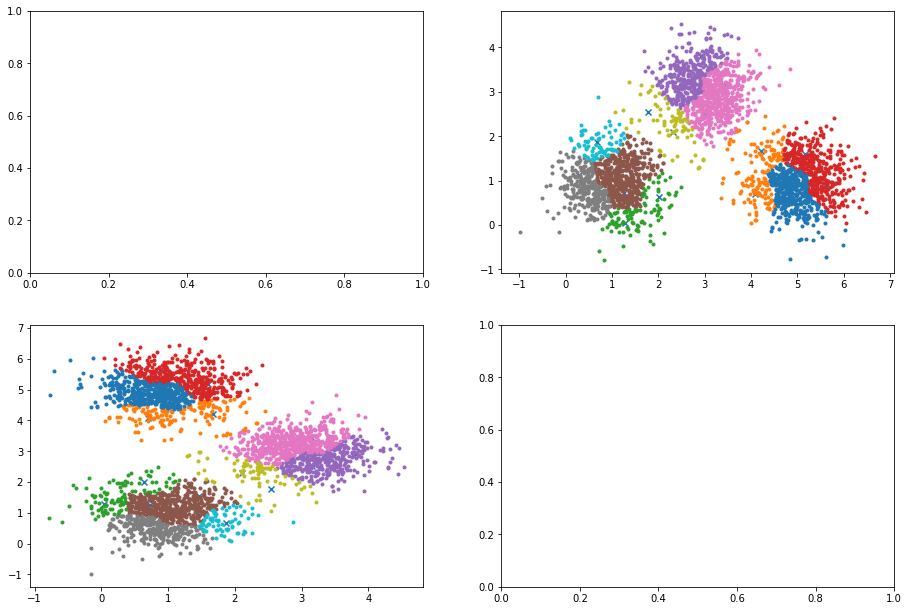

In [44]:
for nc in [2, 3, 10]:
    birch = Birch(n_clusters=nc)
    birch.fit(cloud)
    assess_result(cloud, birch.labels_, birch.subcluster_centers_)
    plot_results(cloud, birch.labels_, birch.subcluster_centers_, max(birch.labels_) + 1)

silhuette: 0.497907935243, dunn: None, davies-bouldin: None


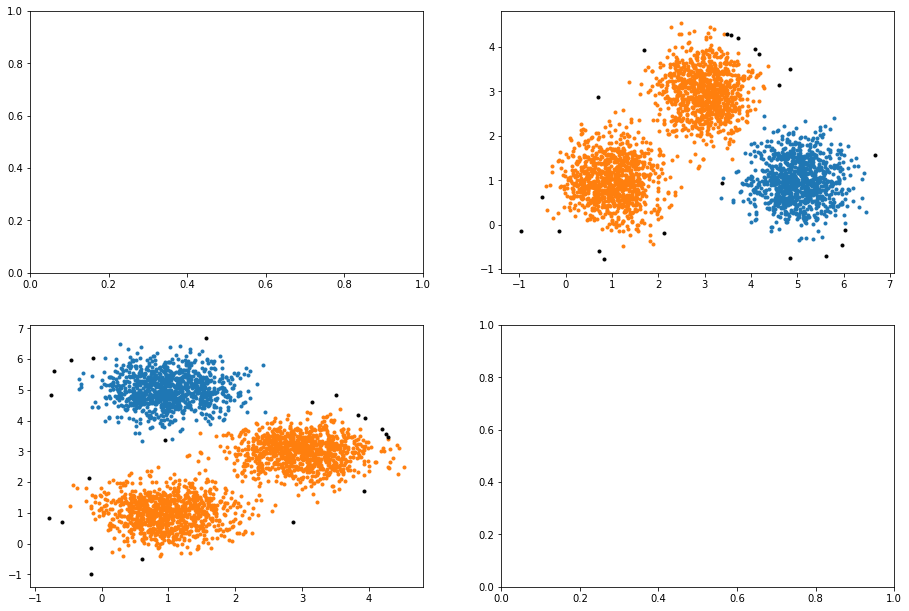

silhuette: 0.652791445204, dunn: None, davies-bouldin: None


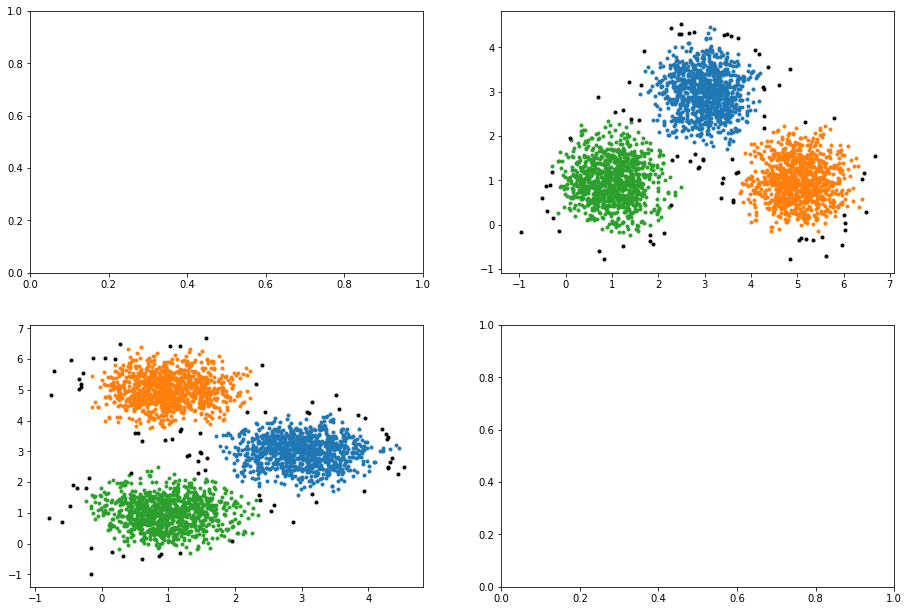

silhuette: -0.354760304441, dunn: None, davies-bouldin: None


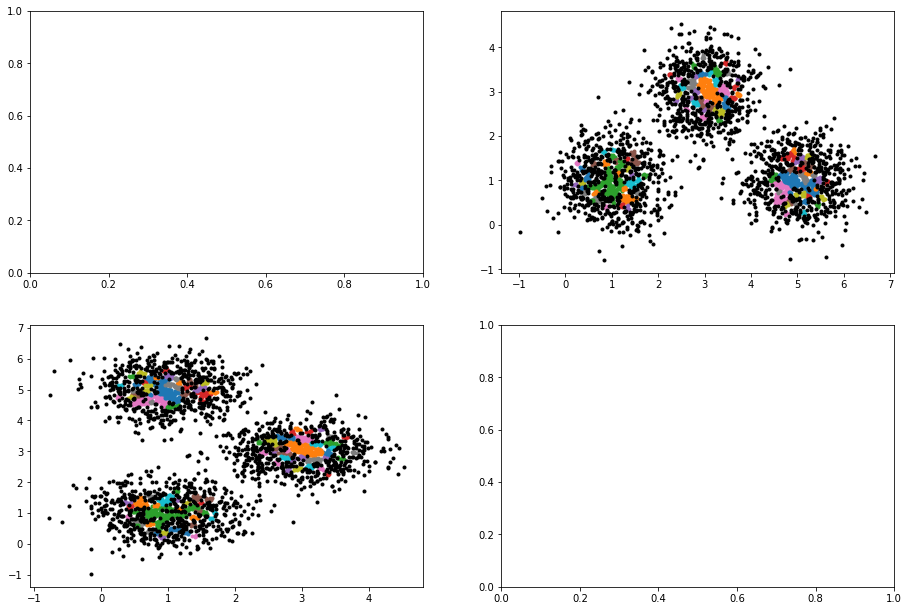

In [49]:
for ep in (0.3, 0.2, 0.05):
    dbscan = DBSCAN(eps=ep)
    dbscan.fit(cloud)
    assess_result(cloud, dbscan.labels_, np.array([]))
#     print(dbscan.labels_)
    plot_results(cloud, dbscan.labels_, np.array([]), max(dbscan.labels_) + 1)

silhuette: 0.550964374642, dunn: 0.691961843846, davies-bouldin: 0.323221043221


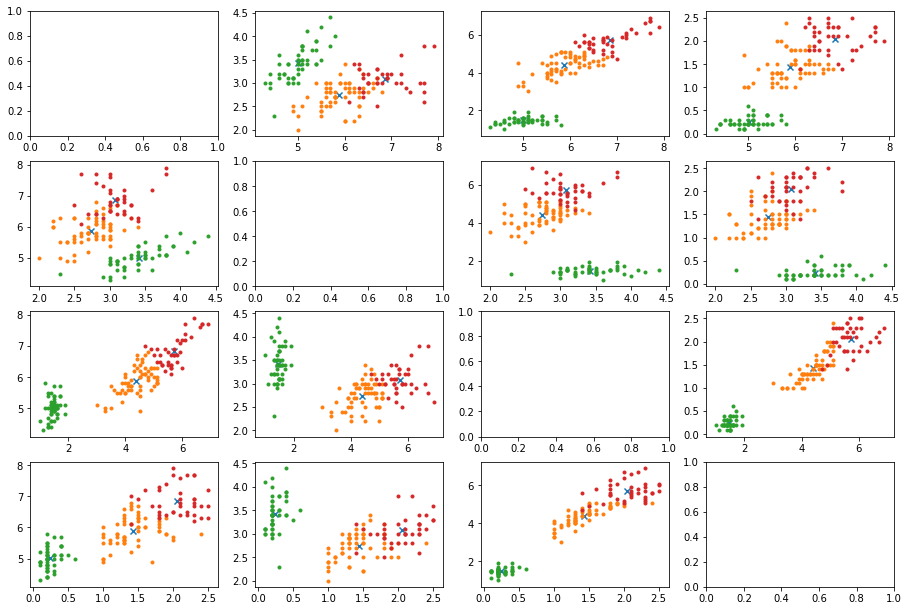

silhuette: 0.552591944521, dunn: 0.671169841783, davies-bouldin: 0.319946211983


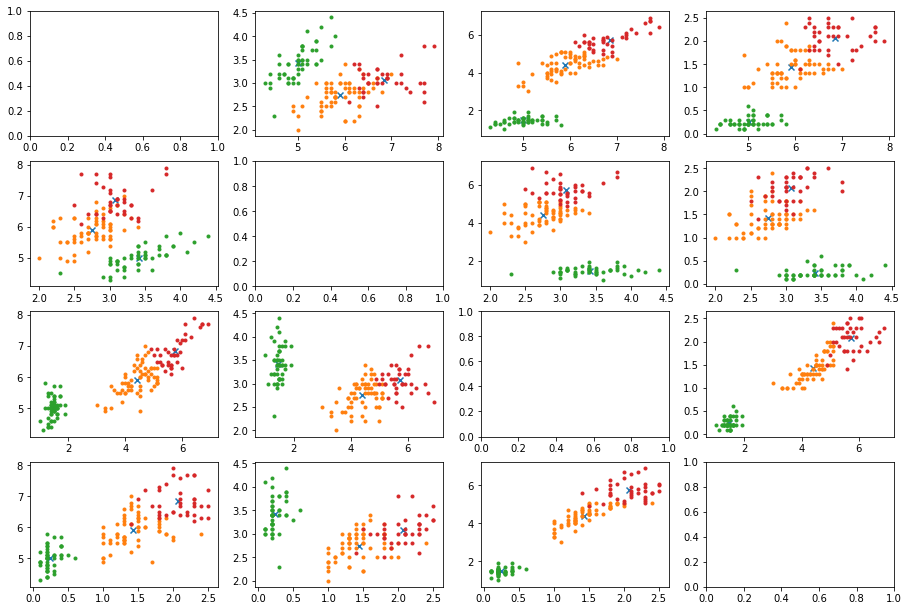

silhuette: 0.552591944521, dunn: 0.671169841783, davies-bouldin: 0.319946211983


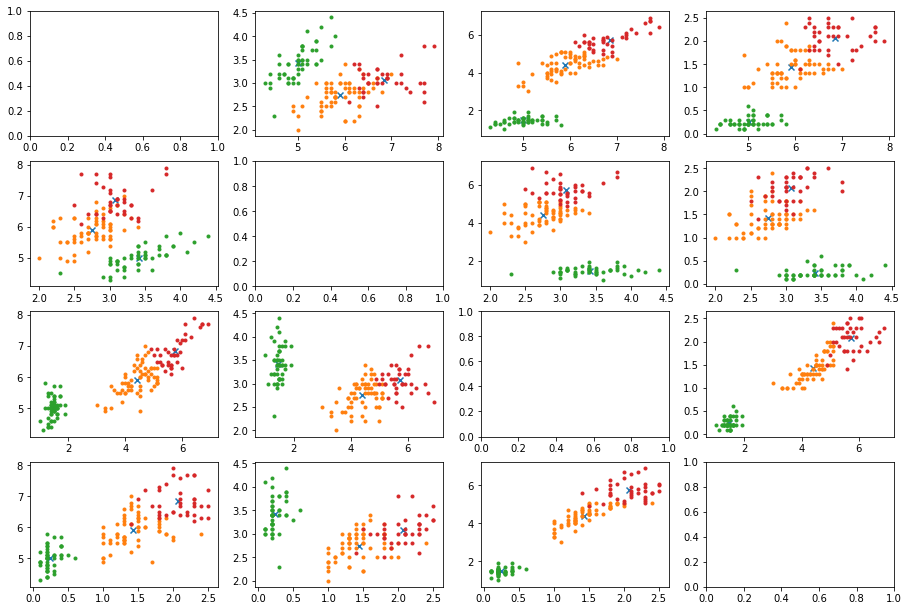

silhuette: 0.552591944521, dunn: 0.671169841783, davies-bouldin: 0.319946211983


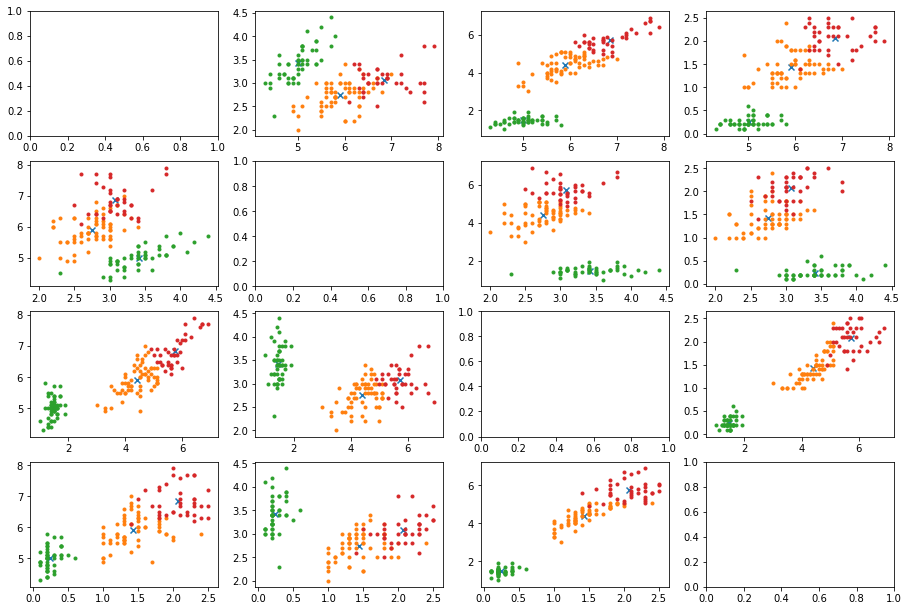

silhuette: 0.552591944521, dunn: 0.671169841783, davies-bouldin: 0.319946211983


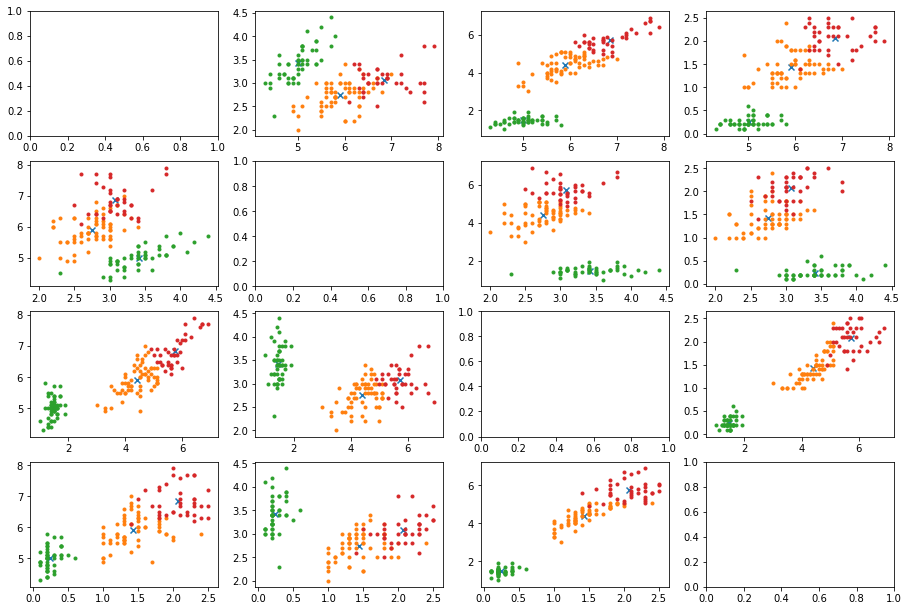

In [36]:
##### task 0 #####
##### a #####

# n_init: int, default 10
# Number of time the k-means algorithm will be run with different centroid seeds. 
# The final results will be the best output of n_init consecutive runs in terms of inertia.

# Generally - the greater n_init the better chance of satisfying result
iris = datasets.load_iris() 
k = 3
for ni in [2, 3, 4, 10, 20]:
    kmeans = KMeans(k, n_init=ni)
    kmeans.fit(iris.data)
    assess_result(iris.data, kmeans.labels_, kmeans.cluster_centers_)
    plot_results(iris.data, kmeans.labels_, kmeans.cluster_centers_, k)

silhuette: 0.541135625283, dunn: 0.132520635734, davies-bouldin: 3.23463372559


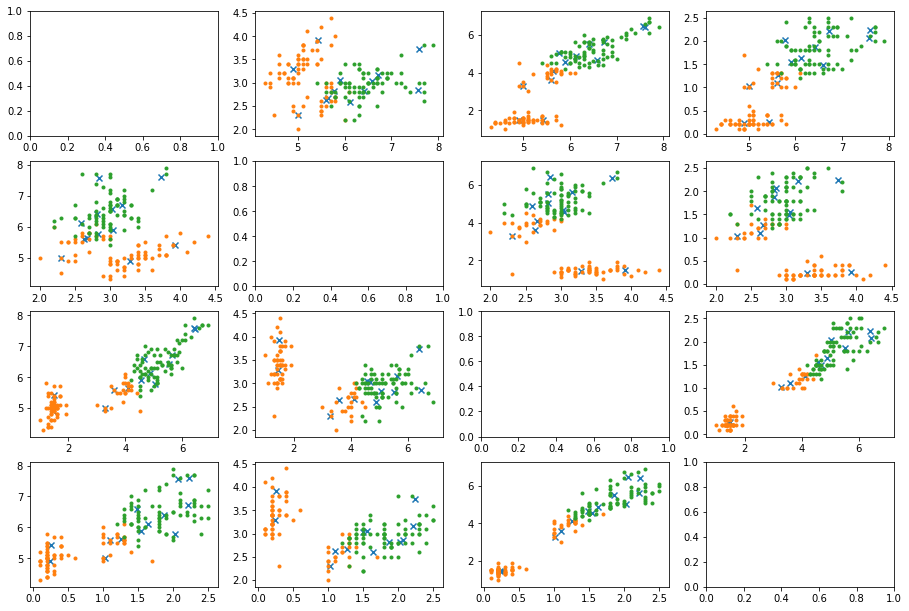

silhuette: 0.501699257072, dunn: 0.154946525717, davies-bouldin: 3.12040780474


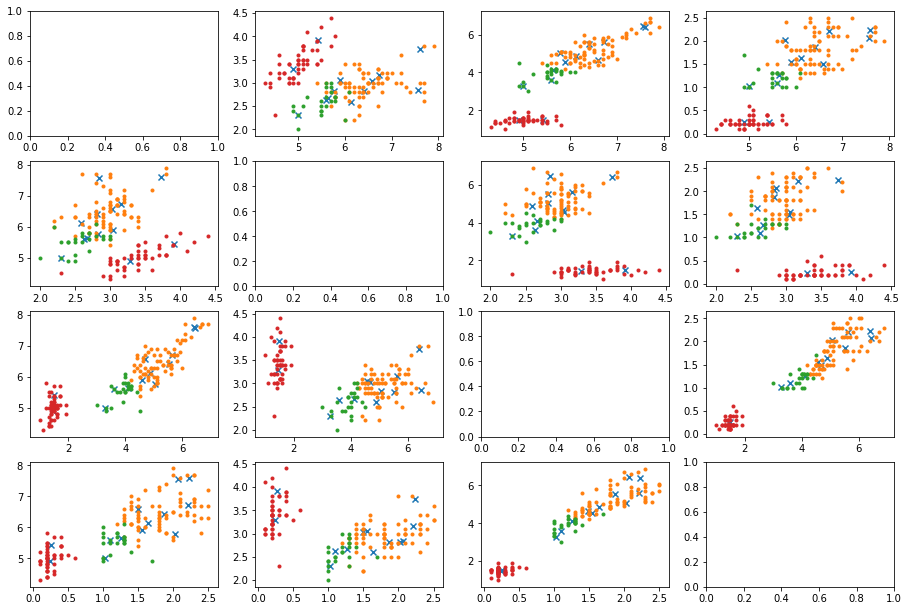

silhuette: 0.329681950448, dunn: 0.359608275581, davies-bouldin: 5.0861999719


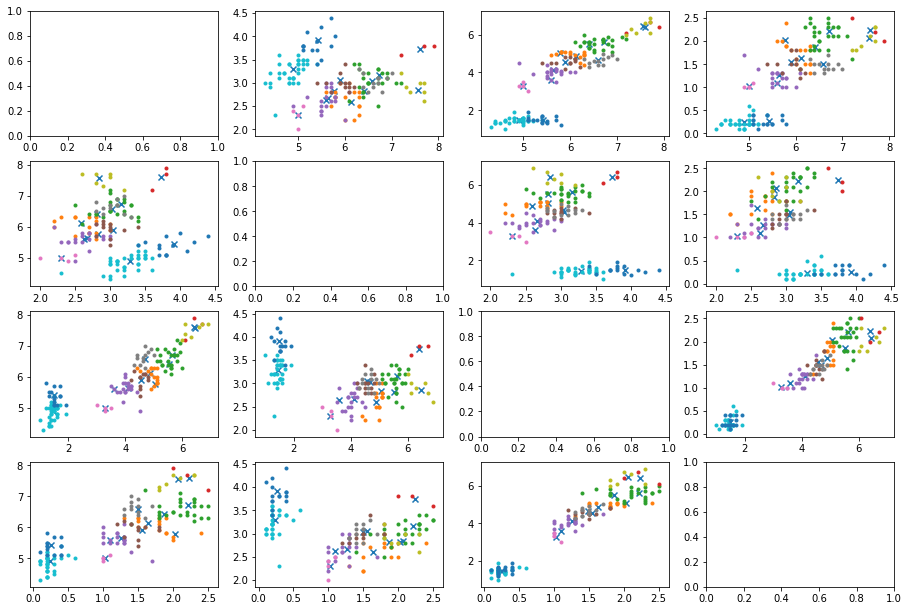

In [37]:
##### b #####
from sklearn.cluster import Birch
# threshold : float, default 0.5
# The radius of the subcluster obtained by merging a new sample and the closest subcluster should be lesser than the threshold. Otherwise a new subcluster is started. 
# Setting this value to be very low promotes splitting and vice-versa.
for nc in [2, 3, 10]:
    birch = Birch(n_clusters=nc)
    birch.fit(iris.data)
    assess_result(iris.data, birch.labels_, birch.subcluster_centers_)
    plot_results(iris.data, birch.labels_, birch.subcluster_centers_, max(birch.labels_) + 1)


silhuette: -0.0518387287002, dunn: None, davies-bouldin: None


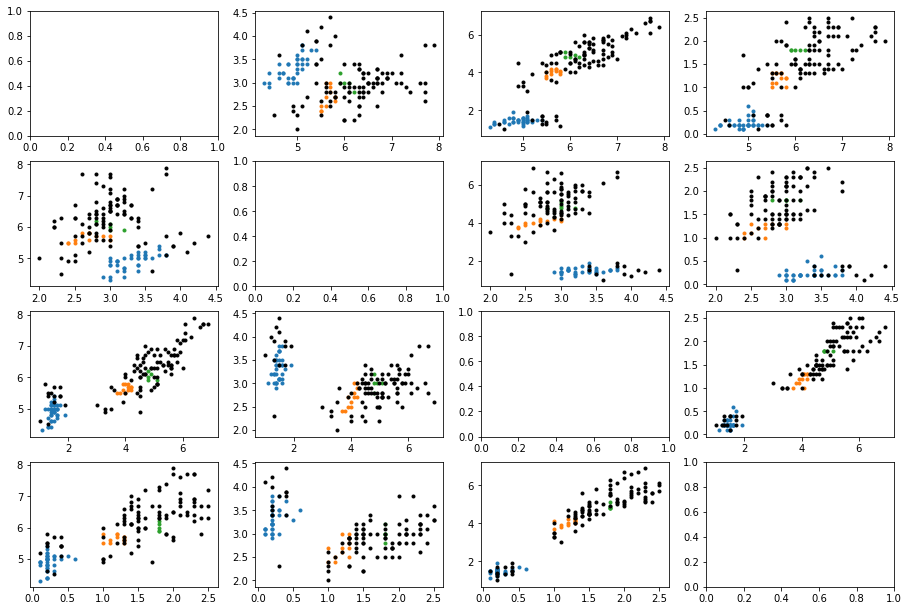

silhuette: 0.194528520149, dunn: None, davies-bouldin: None


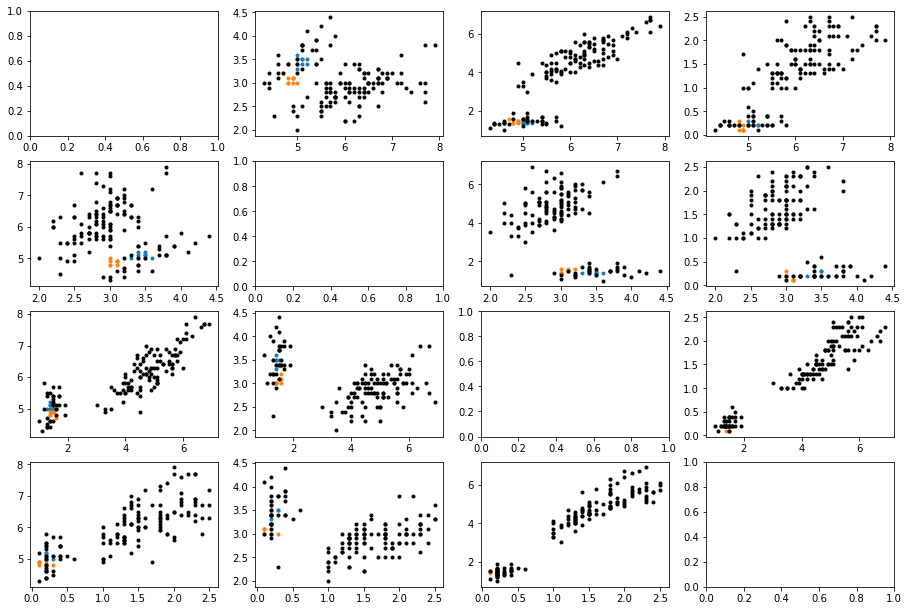

In [38]:
##### c #####
from sklearn.cluster import DBSCAN
# eps : float, optional
# The maximum distance between two samples for them to be considered as in the same neighborhood.
for ep in (0.3, 0.2):
    dbscan = DBSCAN(eps=ep)
    dbscan.fit(iris.data)
    assess_result(iris.data, dbscan.labels_, np.array([]))
    plot_results(iris.data, dbscan.labels_, np.array([]), k)

[ 0  3  1  1  0  2  1  0  4  3  2  8  3  4  5  6  2  0  2  0  0  0  7  8  8
  3  8  0  0  1  3 10  9  9  3  3 10  3  4  0  0 11  4  8 12  3  0  1  2  3
 20 21 20 13 23 22 21 14 23 15 14 22 24 25 16 23 29 17 26 13 27 17 25 25 23
 23 20 20 22 16 13 13 17 28 29 27 20 26 18 13 30 31 17 14 30 18 18 31 19 18
 32 28 33 34 34 35 36 37 38 39 40 41 42 28 43 40 34 44 45 46 42 47 35 41 42
 33 41 48 34 33 37 44 34 49 50 51 32 34 48 42 42 52 28 42 42 52 41 40 53 48]


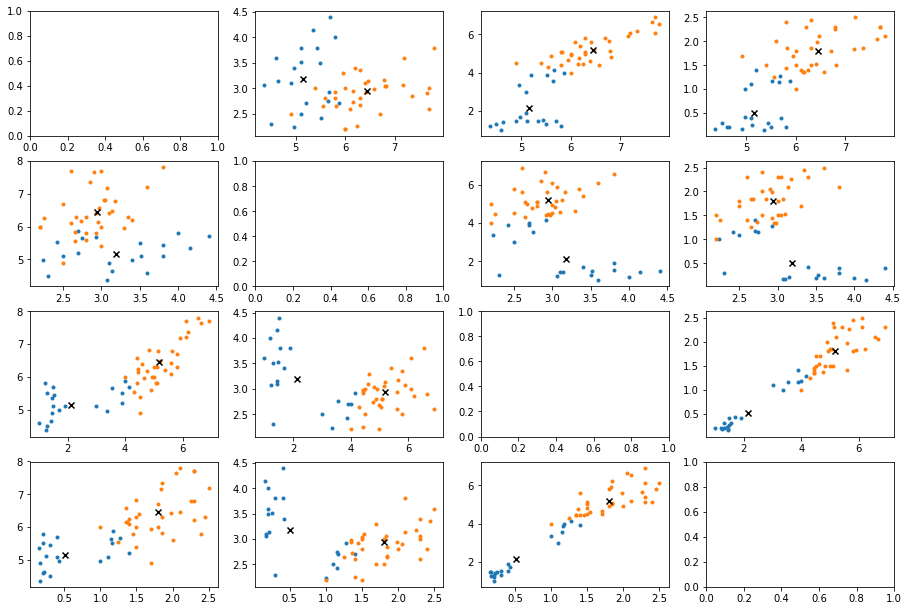

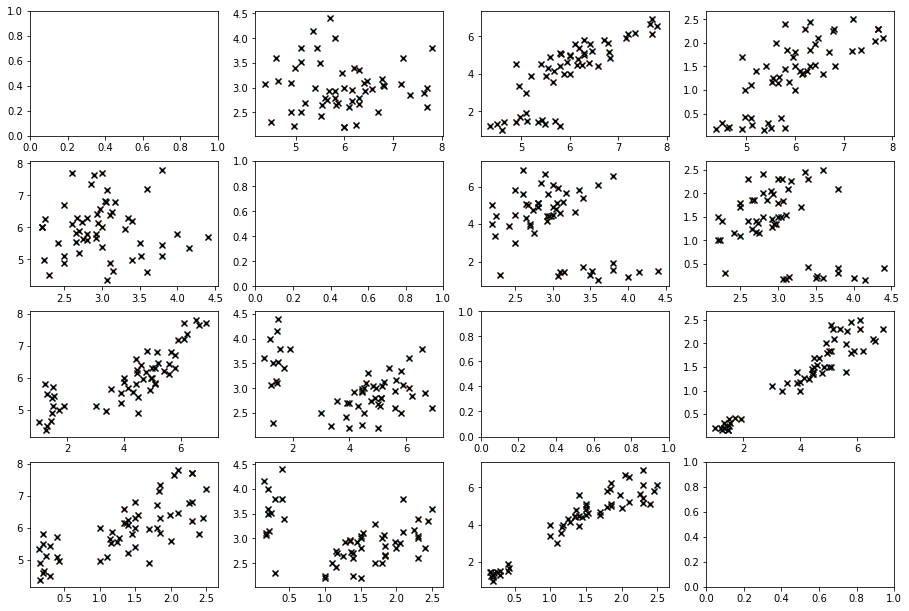

In [35]:
#### 2 #####
from sklearn.cluster import Birch

def points_under_node(node):
    if node.child_ == None:
        return [node.centroid_]
    else:
        pts = []
        for sc in node.child_.subclusters_:
            pts = pts + points_under_node(sc)
        return pts

def plot_birch(data, scs):
    d = data.shape[1]
    fig, axes = plt.subplots(d, d)
    fig.subplots_adjust(left=0, right=2, top=2, bottom=0, hspace=.2, wspace=.2)
    subpl_num = 0
    for d1 in np.arange(d):
        for d2 in np.arange(d):
            subpl_num += 1
            for sc in scs:
                if d1 != d2:
                    plt.subplot(d, d, subpl_num)
                    pts = np.array(points_under_node(sc))
                    plt.scatter(pts[:, d1], pts[:, d2], marker='.')
                    plt.scatter(sc.centroid_[d1], sc.centroid_[d2], marker='x', color='black')
    plt.show()
    if scs[0].child_ != None:
        new_scs = []
        for sc in scs:
            new_scs = new_scs + sc.child_.subclusters_
        plot_birch(data, new_scs)

# threshold : float, default 0.5
# The radius of the subcluster obtained by merging a new sample and the closest subcluster should be lesser than the threshold. Otherwise a new subcluster is started. 
# Setting this value to be very low promotes splitting and vice-versa.

birch = Birch(threshold=0.25, n_clusters=None)
birch.fit(iris.data)
print(birch.labels_)
# print(birch.root_.subclusters_[0].child_.subclusters_[0].centroid_)
plot_birch(iris.data, birch.root_.subclusters_)


In [8]:
import matplotlib.colors as colors
from itertools import cycle

def plotClustering(X, plt_labels):
    plt_colors = cycle(colors.cnames.keys())

    plt_K = np.unique(plt_labels).size

    for k in xrange(plt_K):
        color = plt_colors.next()
        mask = (plt_labels == k)
        plt.plot(X[mask, 0], X[mask, 1], 'w', markerfacecolor=color, marker='o')

    plt.show()

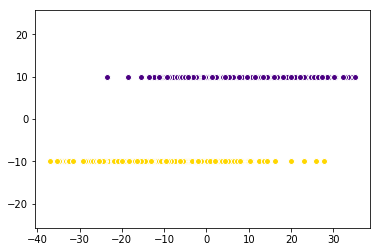

In [17]:
centers1 = [[10.0, 10000.0], [-10, -10000]]
data, labels = datasets.make_blobs(n_samples=1000, n_features=2, centers=centers1, cluster_std=10)
data[:,1] *= 0.001
plt.axis('equal')
plotClustering(data, labels)

silhuette: 0.541180855521, dunn: 0.362781591401, davies-bouldin: 0.490890741862


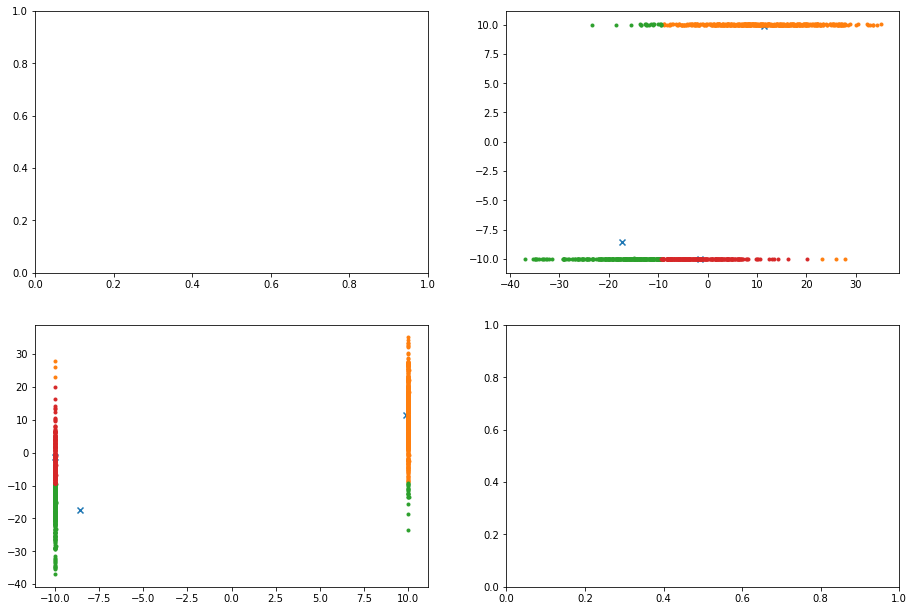

In [18]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=100)
k_means.fit(data)

assess_result(data, k_means.labels_, k_means.cluster_centers_)
plot_results(data, k_means.labels_, k_means.cluster_centers_, 3)

Normalized


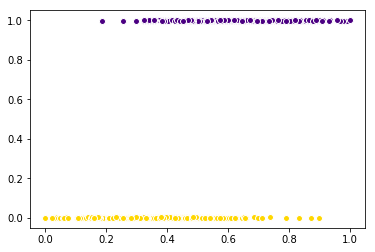

Standardized


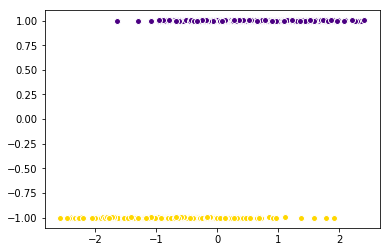

In [19]:
def normalize(X):
    xmin = np.min(X, axis=0)
    xmax = np.max(X, axis=0)
    return (X - xmin) / (xmax - xmin)

def standarize(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

std = standarize(data)

norm = normalize(data)
print 'Normalized'
plotClustering(norm, labels)
print 'Standardized'
plotClustering(std, labels)

silhuette: 0.609398963995, dunn: 0.64120727706, davies-bouldin: 0.341154514476


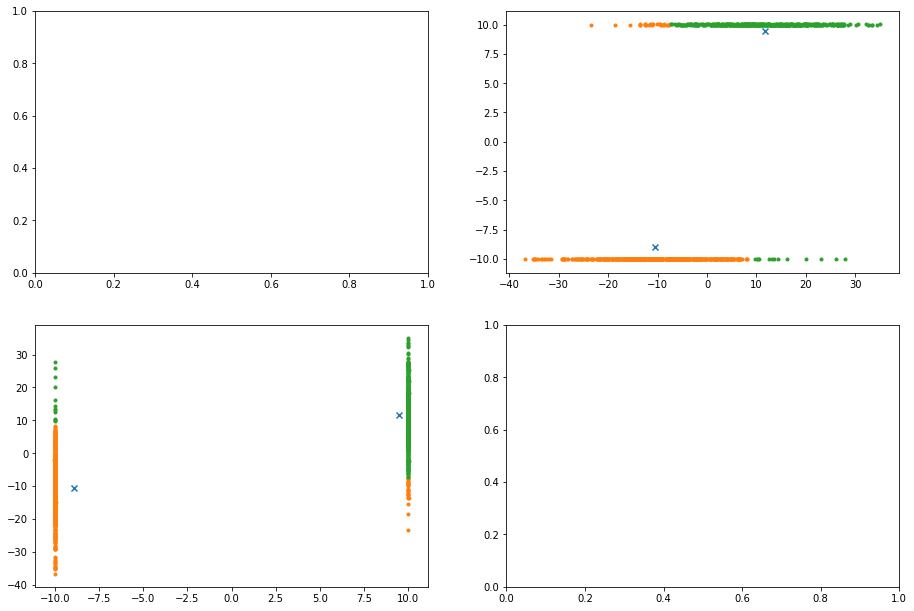

silhuette: 0.847131358103, dunn: 1.15088228166, davies-bouldin: 0.138045174444


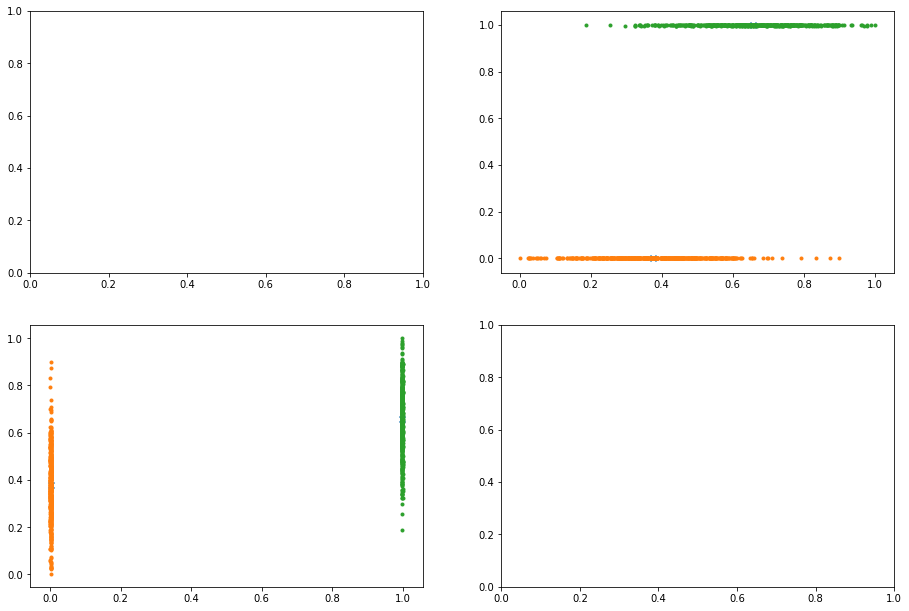

silhuette: 0.684214851369, dunn: 0.617128585914, davies-bouldin: 0.290362482386


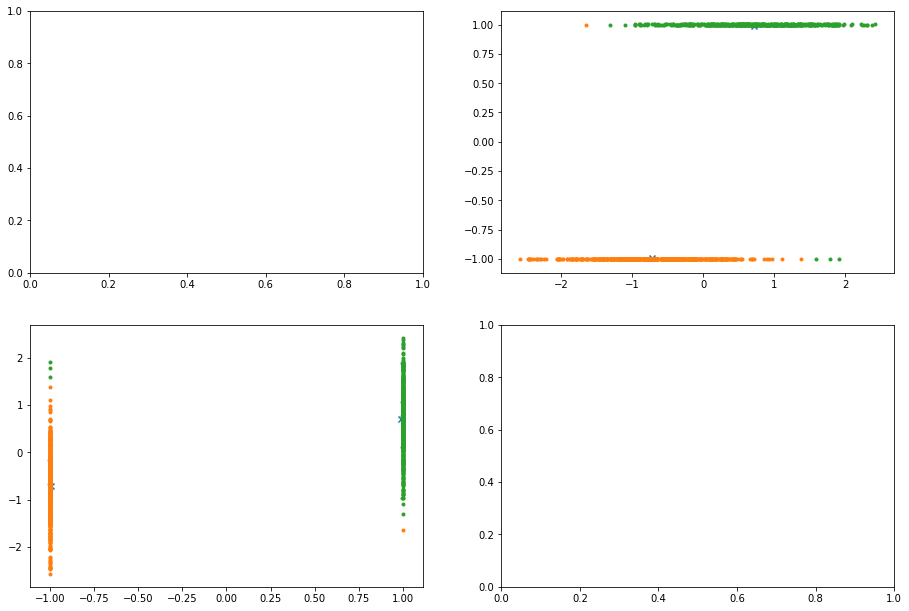

In [20]:
for d in (data, norm, std):
    k_means = KMeans(n_clusters=2, n_init=100)
    k_means.fit(d)

    assess_result(d, k_means.labels_, k_means.cluster_centers_)
    plot_results(d, k_means.labels_, k_means.cluster_centers_, 2)

silhuette: 0.558919392333, dunn: 0.00102800345408, davies-bouldin: 11.6317442112


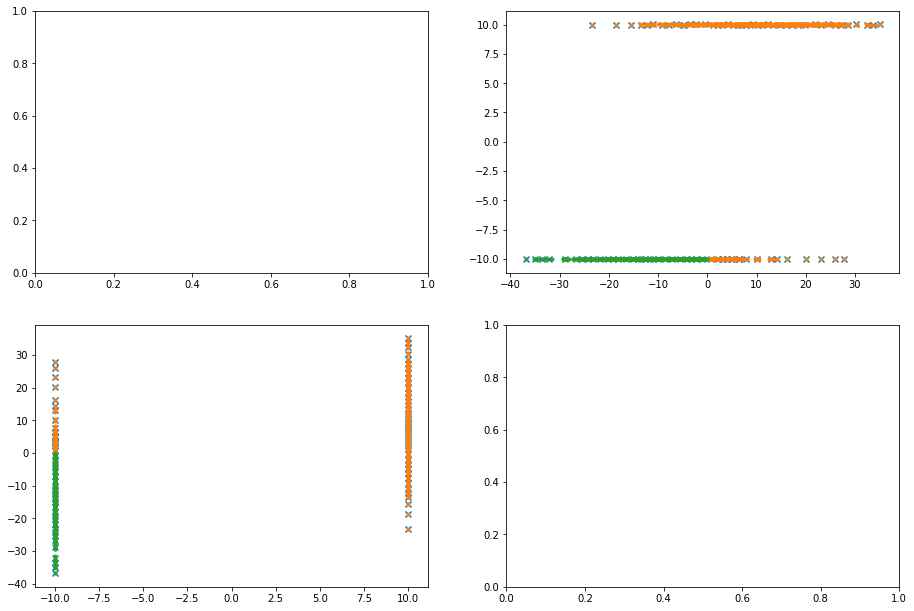

silhuette: 0.847131358103, dunn: 1.14667749602, davies-bouldin: 0.968426689768


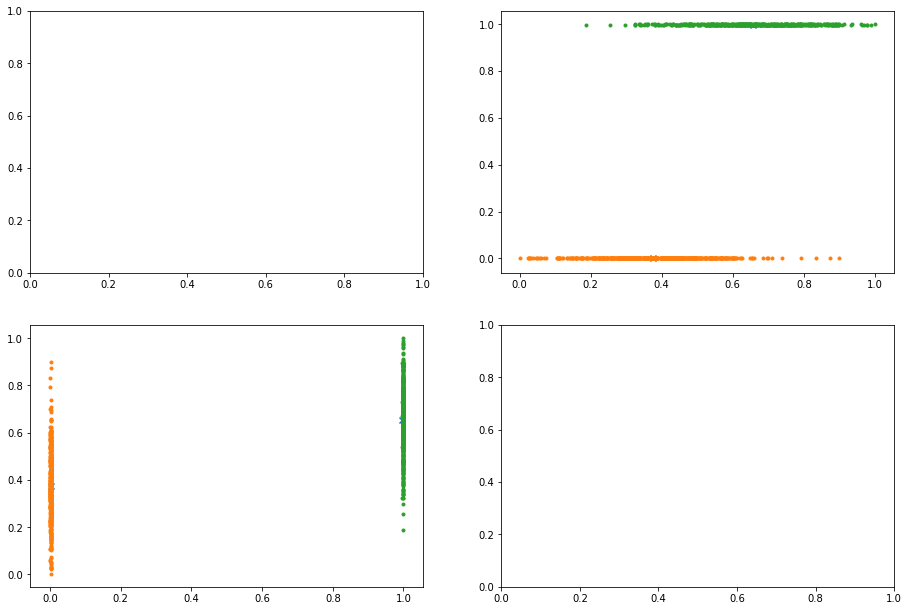

silhuette: 0.684024918223, dunn: 0.20219846787, davies-bouldin: 0.32253530295


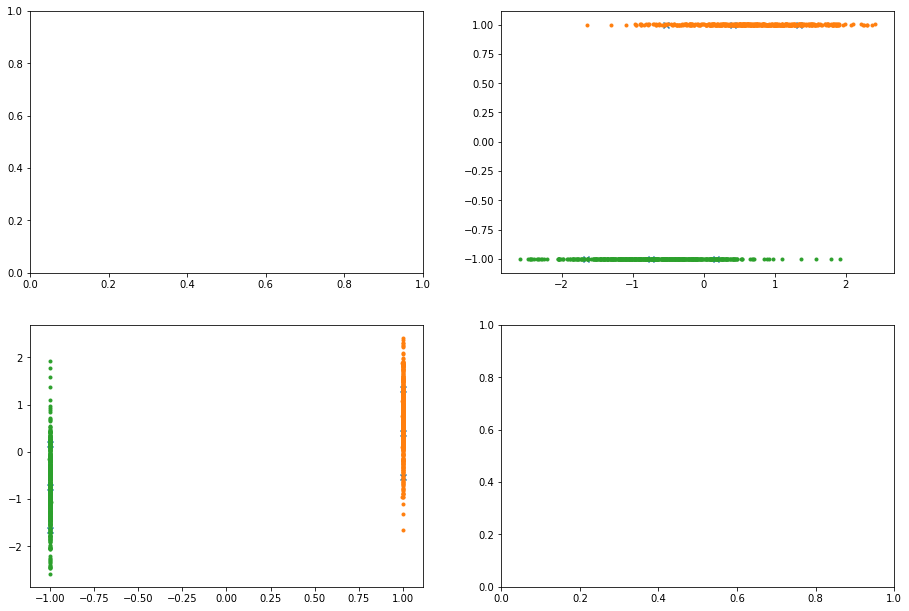

In [21]:
for d in (data, norm, std):
    birch = Birch(n_clusters=2)
    birch.fit(d)

    assess_result(d, birch.labels_, birch.subcluster_centers_)
    plot_results(d, birch.labels_, birch.subcluster_centers_, 2)

silhuette: 0.264880333062, dunn: None, davies-bouldin: None


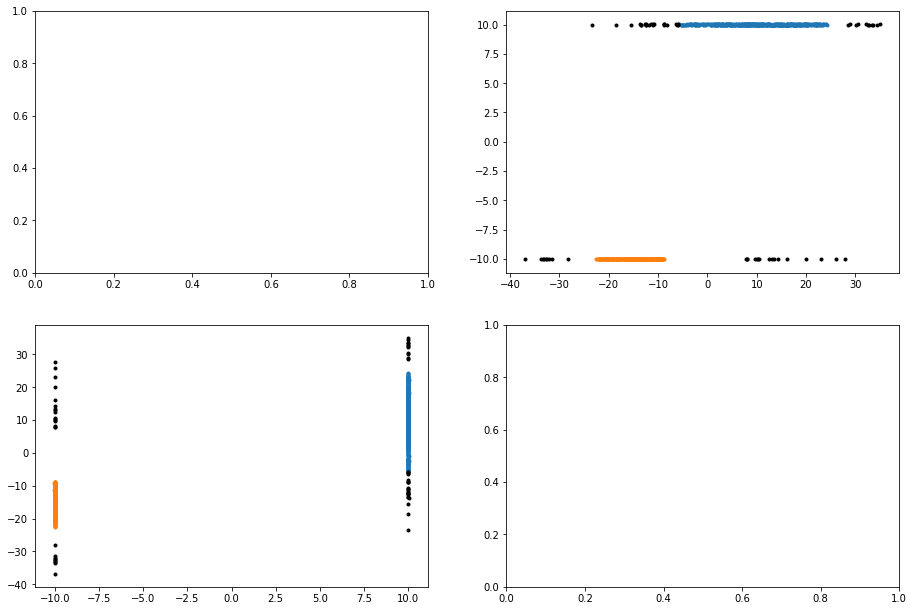

silhuette: 0.847131358103, dunn: None, davies-bouldin: None


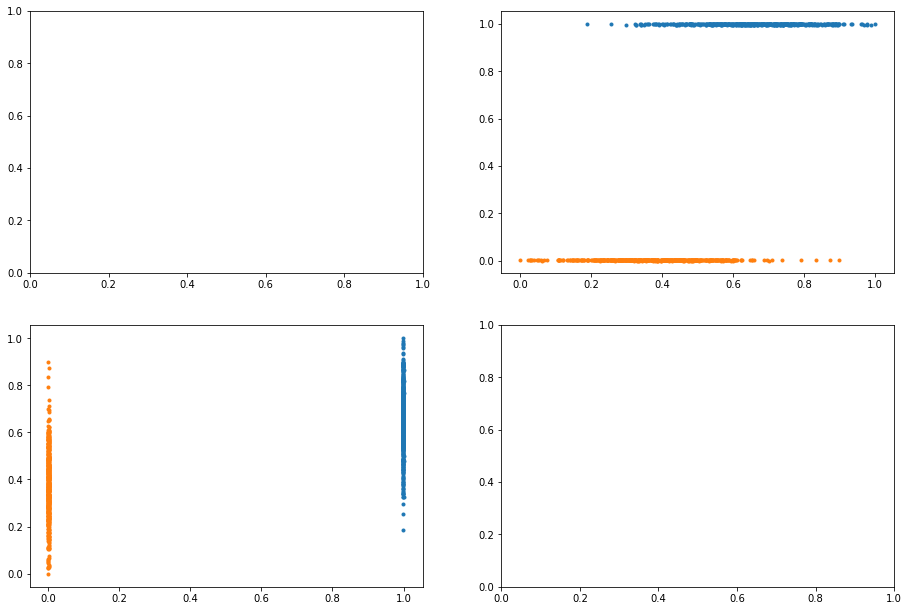

silhuette: 0.684024918223, dunn: None, davies-bouldin: None


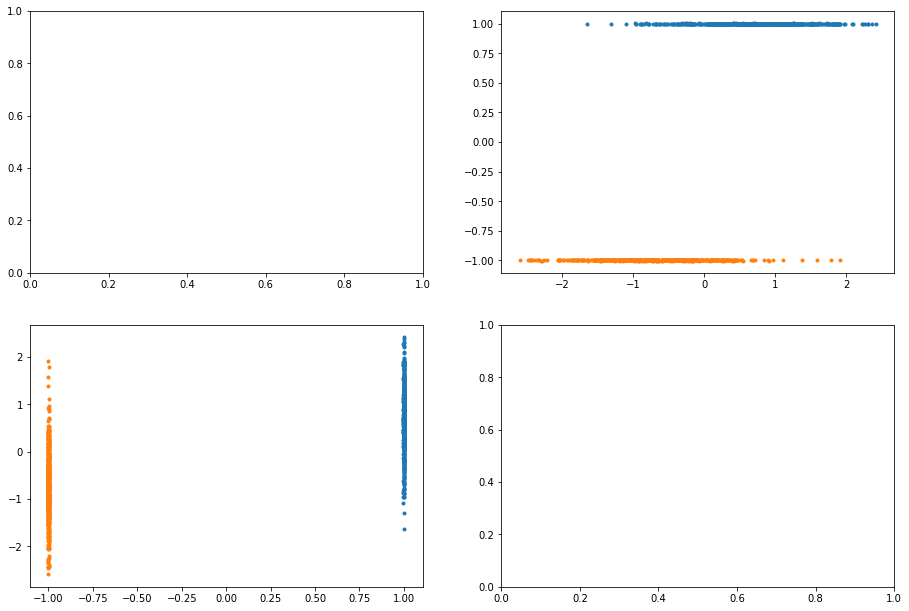

In [22]:
for d in (data, norm, std):
    db = DBSCAN()
    db.fit(d)

    assess_result(d, db.labels_, np.array([]))
    plot_results(d, db.labels_, np.array([]), 2)